In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from scipy.special import expit

import variational_rate_of_aging_monotonic_autoencoder

## Simulated data generation

This is a simple example with just one aging dimension. 
We use C to denote the rate of aging, and R to denote the bias vector.
(Warning: This is different than the notation in the paper, which is confusing! In the paper we use r to denote the rate of aging, and b to denote the bias vector.)

C is sampled as a truncated log-normal and R as a Gaussian. 
The observed X is a sigmoid function of C, plus R, plus noise.
X has 100 dimensions; these dimensions are based on the same (single-dimensional) C and R, 
but with different amounts of added Gaussian noise.

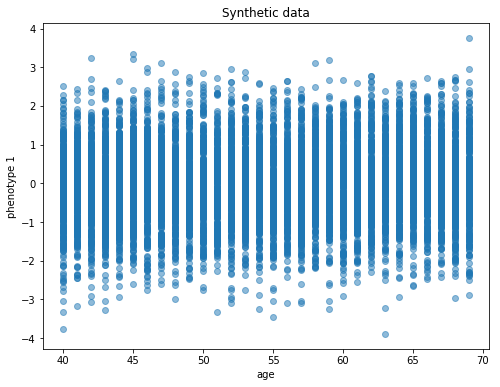

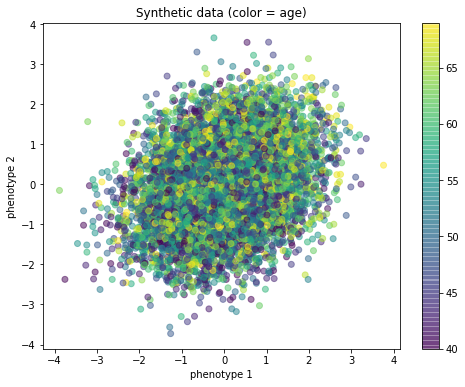

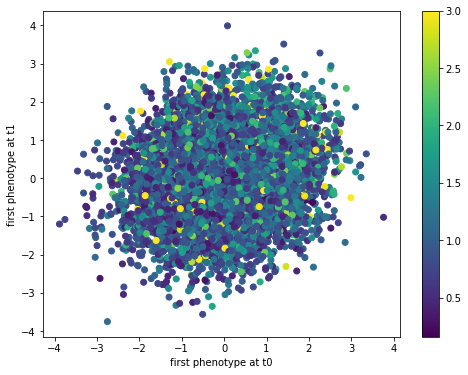

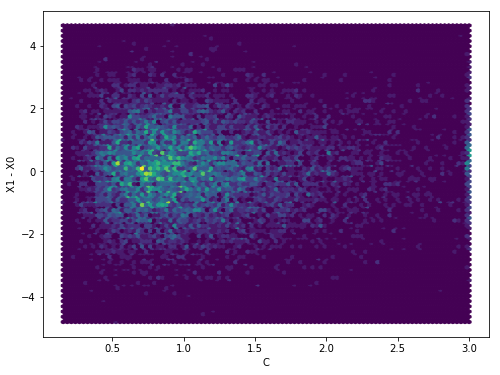

In [2]:
def make_df(X, ages, id_offset=0):
    data_df = pd.DataFrame(X)
    data_df.columns = ['x%s' % i for i in range(data_df.shape[1])]
    data_df['age_sex___age'] = ages
    data_df['individual_id'] = id_offset + np.arange(data_df.shape[0])
    return data_df

def compare_CRs(true_CRs, true_k_age, estimated_CRs, estimated_k_age):
    corrs = np.zeros((true_CRs.shape[1], estimated_CRs.shape[1]))
    fig, axs = plt.subplots(true_CRs_cs.shape[1], model.k, figsize=(16,14))

    for i in range(estimated_CRs.shape[1]):
        if i < estimated_k_age:
            ilabel = 'c%s' % i
        else:
            ilabel = 'r%s' % (i - estimated_k_age)
        axs[0][i].set_title('estimated %s' % ilabel)

        for j in range(true_CRs.shape[1]):
            if j < true_k_age:
                ilabel = 'c%s' % j
            else:
                ilabel = 'r%s' % (j - true_k_age)            
            axs[j][0].set_ylabel('true %s' % ilabel)

            im = axs[j][i].hexbin(
                estimated_CRs[:, i], 
                true_CRs[:, j])
            r, p = pearsonr(estimated_CRs[:, i], true_CRs[:, j])
            axs[j][i].set_xlabel('true %s, estimated %s, r = %s' % (j, i, r))

            corrs[j, i] = r

    plt.show()
    return corrs

def create_data(compute_X, num_C=1, num_R=1):
    np.random.seed(0)

    n_cs = 10000
    n_lon = 1000
    n = n_cs + n_lon
    max_age = 70 # exclusive
    min_age = 40 # inclusive
    max_followup = 20 # inclusive
    min_followup = 5 # inclusive
    aging_rate_scaling_factor = 0.5
    ages0 = np.random.randint(low=min_age, high=max_age, size=(n, 1))
    ages1 = ages0 + np.random.randint(low=min_followup, high=max_followup+1, size=(n, 1))

    C = np.exp(aging_rate_scaling_factor * np.random.randn(n, num_C))
    C[C > 3] = 3
    R = np.random.randn(n, num_R)
    true_k_age = C.shape[1]

    X0, X1 = compute_X(ages0, ages1, max_age, n, C, R)

    mu = np.mean(X0, axis=0)
    sigma = np.std(X0, axis=0, ddof=1)
    X0 = (X0 - mu.reshape((1, -1))) / sigma.reshape((1, -1))
    X1 = (X1 - mu.reshape((1, -1))) / sigma.reshape((1, -1))

    X0_cs = X0[:n_cs, :]
    X1_cs = X1[:n_cs, :]
    X0_lon = X0[n_cs:, :]
    X1_lon = X1[n_cs:, :]

    ages0_cs = ages0[:n_cs, :]
    ages1_cs = ages1[:n_cs, :]
    ages0_lon = ages0[n_cs:, :]
    ages1_lon = ages1[n_cs:, :]

    train_df = make_df(X0_cs, ages0_cs)
    train_lon_df0 = make_df(X0_lon, ages0_lon, id_offset=n_cs)
    train_lon_df1 = make_df(X1_lon, ages1_lon, id_offset=n_cs)

    true_CRs_cs = np.concatenate((C[:n_cs, ...], R[:n_cs, ...]), axis=1)
    true_CRs_lon = np.concatenate((C[n_cs:, ...], R[n_cs:, ...]), axis=1)

    plt.figure(figsize=(8, 6))
    plt.scatter(
        train_df['age_sex___age'],
        train_df.iloc[:, 0],
        alpha=0.5)
    plt.title('Synthetic data')
    plt.xlabel('age')
    plt.ylabel('phenotype 1')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(
        train_df.iloc[:, 0],
        train_df.iloc[:, 1],
        c=train_df['age_sex___age'],
        alpha=0.5)
    plt.colorbar()
    plt.title('Synthetic data (color = age)')
    plt.xlabel('phenotype 1')
    plt.ylabel('phenotype 2')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(
        X0_cs[:, 0],
        X1_cs[:, 0],
        c=C[:n_cs]
    )
    plt.xlabel('first phenotype at t0')
    plt.ylabel('first phenotype at t1')
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hexbin(
        C[:n_cs].reshape(-1),
        (X1_cs[:, 0] - X0_cs[:, 0]).reshape(-1),
    )
    plt.xlabel('C')
    plt.ylabel('X1 - X0')
    plt.show()
    
    return true_k_age, train_df, train_lon_df0, train_lon_df1, true_CRs_cs, true_CRs_lon


def compute_X(ages0, ages1, max_age, n, C, R):

    input_dim = 100
    Z_coeffs = np.random.random((1, input_dim))
    R_coeffs = np.random.random((1, input_dim))

    X0 = 10 * expit(ages0 / max_age * 1 * C) * Z_coeffs + R * R_coeffs + 1 * np.random.randn(n, input_dim)
    X1 = 10 * expit(ages1 / max_age * 1 * C) * Z_coeffs + R * R_coeffs + 1 * np.random.randn(n, input_dim)
    
    return X0, X1

true_k_age, train_df, train_lon_df0, train_lon_df1, true_CRs_cs, true_CRs_lon = create_data(compute_X)


## Model training and validation

Model random seed is 1859
initialization scaling is 0.100
Weight constraint method is take_absolute_value
Fitting model using method VariationalRateOfAgingMonotonicAutoencoder.
Train size 10000; valid size 10000
Setting aging rate scaling factor to 0.100
Added encoder layer for Z_age with input dimension 101 and output dimension 10
Added encoder layer for Z_age with input dimension 10 and output dimension 1
Added encoder layer for residual with input dimension 101 and output dimension 10
Added encoder layer for residual with input dimension 10 and output dimension 1
Added decoder layer for Z_age with input dimension 1 and output dimension 100
Added decoder layer for residual with input dimension 1 and output dimension 100
Deleting weight layer decoder_Z_age_h0 because unnecessary for monotonic autoencoder
Deleting bias layer decoder_Z_age_b0 because unnecessary for monotonic autoencoder
Adding monotonic linear layer with input dimension 1 and output dimension 100
Adding nonlinearity po

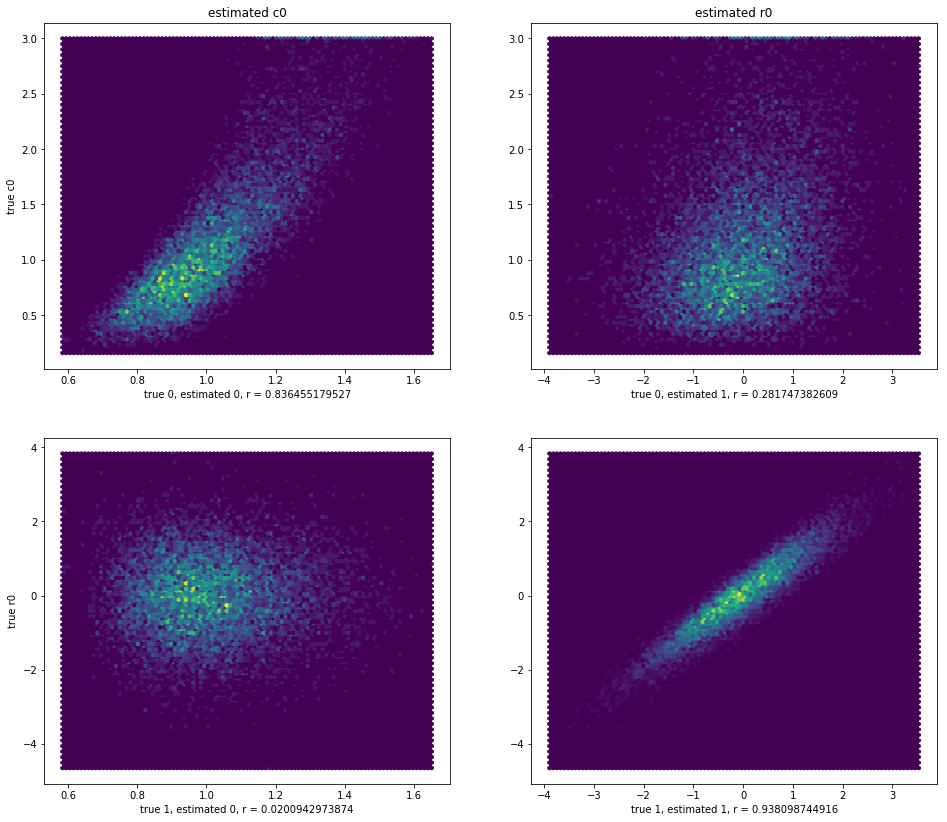

array([[ 0.83645518,  0.28174738],
       [ 0.0200943 ,  0.93809874]])

In [6]:
encoder_layer_sizes = [10, 2]
decoder_layer_sizes = []

model = variational_rate_of_aging_monotonic_autoencoder.VariationalRateOfAgingMonotonicAutoencoder(
    encoder_layer_sizes=encoder_layer_sizes, 
    decoder_layer_sizes=decoder_layer_sizes, 
    learn_continuous_variance=True,
    non_linearity='relu',
    k_age=true_k_age, 
    max_epochs=50, 
    learning_rate=0.01,
    preset_aging_rate_scaling_factor=0.1,
    polynomial_powers_to_fit=[0.2, 0.25, 0.3333333333333333, 0.5, 1, 2, 3, 4, 5],
    random_seed=np.random.choice(range(10000)))

model.fit(train_df, train_df, verbose=False)

estimated_Zs = model.get_projections(train_df, project_onto_mean=True)
estimated_Zs = estimated_Zs.drop('individual_id', 1)
estimated_CRs = estimated_Zs.values
for i in range(model.k_age):
    preprocessed_ages = model.age_preprocessing_function(train_df['age_sex___age'])
    estimated_C = estimated_Zs['z%i' % i] / preprocessed_ages
    estimated_CRs[:, i] = estimated_C

compare_CRs(true_CRs_cs, true_k_age, estimated_CRs, model.k_age)